In [1]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
from torchvision import transforms
from torch.nn import functional as F
from torch import nn
from PIL import Image

In [2]:
#cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Colab解壓縮檔案
# ! unzip "/content/stanford_dogs_dataset.zip"

# Data Preprocessing
### 讀檔

In [4]:
# 資料夾路徑
training_prefix_path = '/content/stanford_dogs_dataset/train/'
testing_prefix_path = '/content/stanford_dogs_dataset/test/'

training_image_folder_list = glob.glob(training_prefix_path + '*')
testing_image_folder_list = glob.glob(testing_prefix_path + '*')
print(training_image_folder_list)
print(testing_image_folder_list)

['/content/stanford_dogs_dataset/train/Afghan_hound', '/content/stanford_dogs_dataset/train/Scottish_deerhound', '/content/stanford_dogs_dataset/train/Leonberg', '/content/stanford_dogs_dataset/train/Irish_wolfhound', '/content/stanford_dogs_dataset/train/Tibetan_terrier', '/content/stanford_dogs_dataset/train/Airedale', '/content/stanford_dogs_dataset/train/basenji', '/content/stanford_dogs_dataset/train/Bernese_mountain_dog']
['/content/stanford_dogs_dataset/test/Afghan_hound', '/content/stanford_dogs_dataset/test/Scottish_deerhound', '/content/stanford_dogs_dataset/test/Leonberg', '/content/stanford_dogs_dataset/test/Irish_wolfhound', '/content/stanford_dogs_dataset/test/Tibetan_terrier', '/content/stanford_dogs_dataset/test/Airedale', '/content/stanford_dogs_dataset/test/basenji', '/content/stanford_dogs_dataset/test/Bernese_mountain_dog']


In [5]:
# 狗狗類別檔名
label_name_list = [_.split('/')[-1] for _ in training_image_folder_list]
print(label_name_list)

['Afghan_hound', 'Scottish_deerhound', 'Leonberg', 'Irish_wolfhound', 'Tibetan_terrier', 'Airedale', 'basenji', 'Bernese_mountain_dog']


### 圖片轉數值資料、轉換資料格式

In [6]:
# transform 圖片 function
preprocess = transforms.Compose([
             transforms.Resize((256, 256)),
             transforms.ToTensor(), # transform to (0, 1)
             transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)), # transform to (-1, 1)
             ])

In [7]:
# load training dataset
if not (os.path.isfile('./images_train_X.npy') and os.path.isfile('./images_train_y.npy')): 
    images = []
    labels = []
    label_count = 0

    for training_image_floder in training_image_folder_list:
        print('load images from: ', training_image_floder )
        imgs_path_list = glob.glob(training_image_floder + '/*')

        for idx, img_path in enumerate(imgs_path_list):
            img = preprocess(Image.open(img_path).convert('RGB'))
            img = img.numpy()

            images.append(img)

        labels.extend([label_count] * len(imgs_path_list))
        label_count += 1

    images = np.array(images)
    labels = np.array(labels)

    np.save('./images_train_X.npy', images)
    np.save('./images_train_y.npy', labels)
    print(images.shape, labels.shape)
else:
    images = np.load('./images_train_X.npy')
    labels = np.load('./images_train_y.npy')

    print(images.shape, labels.shape)
    
train_X = torch.from_numpy(images)
train_y = torch.from_numpy(labels)

(1328, 3, 256, 256) (1328,)


In [8]:
# load testing dataset
if not (os.path.isfile('./images_test_X.npy') and os.path.isfile('./images_test_y.npy')): 
    images = []
    labels = []
    label_count = 0

    for testing_image_floder in testing_image_folder_list:
        print('load images from: ', testing_image_floder )
        imgs_path_list = glob.glob(testing_image_floder + '/*')

        for idx, img_path in enumerate(imgs_path_list):
            img = preprocess(Image.open(img_path).convert('RGB'))
            img = img.numpy()

            images.append(img)

        labels.extend([label_count] * len(imgs_path_list))
        label_count += 1

    images = np.array(images)
    labels = np.array(labels)

    np.save('./images_test_X.npy', images)
    np.save('./images_test_y.npy', labels)
    print(images.shape, labels.shape)
else:
    images = np.load('./images_test_X.npy')
    labels = np.load('./images_test_y.npy')

    print(images.shape, labels.shape)
    
test_X = torch.from_numpy(images)
test_y = torch.from_numpy(labels)

(288, 3, 256, 256) (288,)


In [9]:
# DataLoader
train_dataset = Data.TensorDataset(train_X, train_y)
test_dataset = Data.TensorDataset(test_X, test_y)

train_loader = Data.DataLoader(
    dataset = train_dataset,       
    batch_size = 128,          
    shuffle = True,           
    num_workers=2,              
)

test_loader = Data.DataLoader(
    dataset = test_dataset,      
    batch_size = 64,      
    shuffle = False,
    num_workers=2,              
)

# 2-1

In [10]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Sequential( # input shape:(1, 256, 256)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # output shape: (32, 128, 128)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,  out_channels=64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # output shape: (64, 64, 64)
        )
        self.out = nn.Linear(in_features=64 * 64 * 64, out_features=8)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten
        x = x.view(x.size()[0], -1) # (batch size, 28*28)
        output = self.out(x)
        return output

In [11]:
class module():
    def __init__(self, net, train_loader, test_loader, EPOCH=20, LR=0.0001):
        self.net = net
        self.optimizer = torch.optim.Adam(net.parameters(), lr = LR)
        self.criterion = nn.CrossEntropyLoss()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.EPOCH_ = EPOCH
        self.LR_ = LR

        self.net = self.net.to(device)
        if device == 'cuda':
            self.net = torch.nn.DataParallel(self.net)
            torch.backends.cudnn.benchmark = True

    def start(self):
        history_train_loss = []
        history_test_loss = []
        history_train_acc = []
        history_test_acc = []
        for epoch in range(self.EPOCH_):
            print('Epoch:', epoch+1)
            train_loss, train_acc = self.train()
            test_loss, test_acc = self.test()

            history_train_loss.append(train_loss)
            history_test_loss.append(test_loss)
            history_train_acc.append(train_acc)
            history_test_acc.append(test_acc)
        return history_train_loss, history_test_loss, history_train_acc, history_test_acc

    def train(self):
        self.net.train()
        train_loss = 0
        correct = 0
        total = 0
        for step, (batch_X, batch_y) in enumerate(self.train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            self.optimizer.zero_grad() # 清空前一次的 gradient
            outputs = self.net(batch_X) # 將 data 傳入 model 進行 forward propagation
            loss = self.criterion(outputs, batch_y) # 計算 loss
            loss.backward() # 根據 loss 進行 back propagation，計算 gradient
            self.optimizer.step() # 做 gradient descent
            
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()        

        train_loss = loss.item()
        print('【Training】Loss: %.3f | Acc: %.3f%% (%d/%d)' % ( train_loss, 100.*(correct/total), correct, total ))
        return train_loss, (correct/total)

    def test(self):
        self.net.eval()

        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad(): 
            for step, (batch_X, batch_y) in enumerate(self.test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = self.net(batch_X)
                loss = self.criterion(outputs, batch_y)

                _, predicted = outputs.max(1)
                total += batch_y.size(0)
                correct += predicted.eq(batch_y).sum().item() 

        test_loss = loss.item()
        print('【Testing】Loss: %.3f | Acc: %.3f%% (%d/%d)' % ( test_loss, 100.*(correct/total), correct, total ))
        return test_loss, (correct/total)

In [12]:
cnn1_module = module(CNN_1(), train_loader, test_loader)
history_train_loss, history_test_loss, history_train_acc, history_test_acc = cnn1_module.start()

Epoch: 1
【Training】Loss: 2.004 | Acc: 16.717% (222/1328)
【Testing】Loss: 2.017 | Acc: 24.653% (71/288)
Epoch: 2
【Training】Loss: 1.811 | Acc: 35.241% (468/1328)
【Testing】Loss: 1.698 | Acc: 28.819% (83/288)
Epoch: 3
【Training】Loss: 1.487 | Acc: 43.599% (579/1328)
【Testing】Loss: 2.089 | Acc: 32.639% (94/288)
Epoch: 4
【Training】Loss: 1.244 | Acc: 55.120% (732/1328)
【Testing】Loss: 1.438 | Acc: 34.375% (99/288)
Epoch: 5
【Training】Loss: 1.006 | Acc: 62.500% (830/1328)
【Testing】Loss: 1.444 | Acc: 36.806% (106/288)
Epoch: 6
【Training】Loss: 1.008 | Acc: 72.063% (957/1328)
【Testing】Loss: 2.728 | Acc: 32.986% (95/288)
Epoch: 7
【Training】Loss: 0.927 | Acc: 76.130% (1011/1328)
【Testing】Loss: 2.813 | Acc: 35.069% (101/288)
Epoch: 8
【Training】Loss: 0.630 | Acc: 82.530% (1096/1328)
【Testing】Loss: 1.963 | Acc: 32.986% (95/288)
Epoch: 9
【Training】Loss: 0.454 | Acc: 89.006% (1182/1328)
【Testing】Loss: 1.509 | Acc: 33.333% (96/288)
Epoch: 10
【Training】Loss: 0.216 | Acc: 92.169% (1224/1328)
【Testing】Loss: 1.4

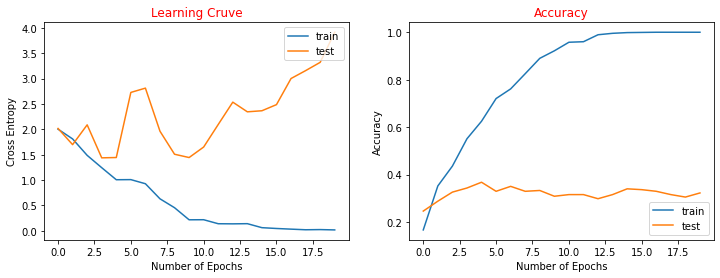

In [13]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_train_loss, label = 'train')
ax[0].plot(history_test_loss, label = 'test')
ax[0].legend(loc=1)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_test_acc, label = 'test')
ax[1].legend(loc=4)

# 2-2 (a)

### Resnet-18

Paper: 

https://arxiv.org/pdf/1512.03385.pdf

參考資料:

https://zhuanlan.zhihu.com/p/163577599

https://zhuanlan.zhihu.com/p/157134695

https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

https://gist.github.com/nikogamulin/7774e0e3988305a78fd73e1c4364aded

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        
        self.left = nn.Sequential(
             # bias=False 是因為 bias 在 BN 中已經有了，如果 stride=2 則 shape 會變成一半
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        
        # 根據情況是否做出增維或是縮小 shape
        self.right = shortcut 
        
    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out = out + residual
        out = F.relu(out)
        return out
    
class ResNet18(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNet18, self).__init__()
        
        self.pre_layer = nn.Sequential(
            #為了使 shape 變一半，stride 必須是 2，在固定 kernel=7 下由公式推得 padding=3
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #為了使 shape 變一半，stride 必須是 2，在固定 kernel=3 下由公式推得 padding=1
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1) , 
        )
        
        self.layer1 = self._make_layer(64, 64, 2) 
        self.layer2 = self._make_layer(64, 128, 2, stride=2)      
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        self.fc = nn.Linear(512, num_classes) # fc: fully connecterd
        
    def _make_layer(self, in_channel, out_channel, block_num, stride=1):
        
        shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        
        layers = []
        
        # 第一次的 ResidualBlock 可能會縮小 shape (根據 stride)，所以要獨立出來做
        layers.append(ResidualBlock(in_channel, out_channel, stride, shortcut)) 
        
        # 第二次以後的 ResidualBlock，不會有維度或大小不同的問題，參數跟shortcut都不用做
        for i in range(1, block_num):
            layers.append(ResidualBlock(out_channel, out_channel))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.pre_layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, x.shape[3]) 
        x = x.view(x.size(0), -1) 
        out = self.fc(x)
        return out

In [15]:
resnet18_module = module(ResNet18(), train_loader, test_loader)
history_train_loss, history_test_loss, history_train_acc, history_test_acc = resnet18_module.start()

Epoch: 1
【Training】Loss: 1.852 | Acc: 24.473% (325/1328)
【Testing】Loss: 2.750 | Acc: 12.500% (36/288)
Epoch: 2
【Training】Loss: 1.692 | Acc: 44.654% (593/1328)
【Testing】Loss: 5.550 | Acc: 12.500% (36/288)
Epoch: 3
【Training】Loss: 1.061 | Acc: 60.994% (810/1328)
【Testing】Loss: 6.006 | Acc: 14.236% (41/288)
Epoch: 4
【Training】Loss: 0.505 | Acc: 80.572% (1070/1328)
【Testing】Loss: 2.831 | Acc: 23.611% (68/288)
Epoch: 5
【Training】Loss: 0.238 | Acc: 95.105% (1263/1328)
【Testing】Loss: 3.681 | Acc: 26.736% (77/288)
Epoch: 6
【Training】Loss: 0.102 | Acc: 99.473% (1321/1328)
【Testing】Loss: 4.086 | Acc: 23.958% (69/288)
Epoch: 7
【Training】Loss: 0.058 | Acc: 99.473% (1321/1328)
【Testing】Loss: 2.020 | Acc: 30.556% (88/288)
Epoch: 8
【Training】Loss: 0.032 | Acc: 99.699% (1324/1328)
【Testing】Loss: 1.123 | Acc: 32.292% (93/288)
Epoch: 9
【Training】Loss: 0.024 | Acc: 100.000% (1328/1328)
【Testing】Loss: 2.561 | Acc: 33.333% (96/288)
Epoch: 10
【Training】Loss: 0.013 | Acc: 100.000% (1328/1328)
【Testing】Loss: 

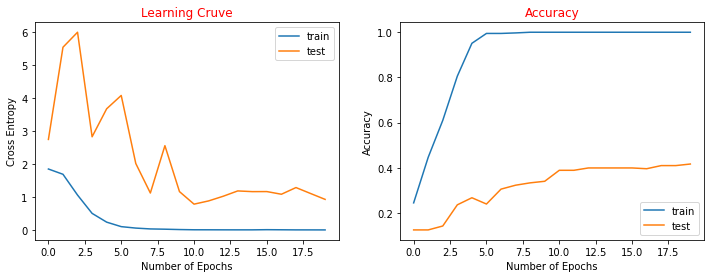

In [16]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_train_loss, label = 'train')
ax[0].plot(history_test_loss, label = 'test')
ax[0].legend(loc=1)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_test_acc, label = 'test')
ax[1].legend(loc=4)

# 2-2 (b)

In [17]:
class Restnet18_no_mapping(nn.Module):
    def __init__(self):
        super(Restnet18_no_mapping, self).__init__()
        
        self.pre_layer = nn.Sequential( # input shape:(1, 256, 256)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layer1 = self._make_layer(64, 64, 4, stride=1)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.fc = nn.Linear(512, 8) # fc: fully connecterd

    def _make_layer(self, in_channel, out_channel, block_num, stride=1):
        
        layers = []

        if stride!=1:
            layers.append(
            nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU())    
            )

        for i in range(block_num):
            layers.append(
            nn.Sequential(
            nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU())
        )
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        x = self.pre_layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, x.shape[3]) 
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

In [18]:
Restnet18_no_mapping_module = module(Restnet18_no_mapping(), train_loader, test_loader)
history_train_loss_no_mapping, history_test_loss_no_mapping, history_train_acc_no_mapping, history_test_acc_no_mapping = Restnet18_no_mapping_module.start()

Epoch: 1
【Training】Loss: 1.827 | Acc: 19.955% (265/1328)
【Testing】Loss: 2.510 | Acc: 12.500% (36/288)
Epoch: 2
【Training】Loss: 1.665 | Acc: 37.500% (498/1328)
【Testing】Loss: 4.149 | Acc: 12.500% (36/288)
Epoch: 3
【Training】Loss: 0.999 | Acc: 55.723% (740/1328)
【Testing】Loss: 4.305 | Acc: 12.500% (36/288)
Epoch: 4
【Training】Loss: 0.946 | Acc: 73.720% (979/1328)
【Testing】Loss: 4.677 | Acc: 20.139% (58/288)
Epoch: 5
【Training】Loss: 0.434 | Acc: 92.997% (1235/1328)
【Testing】Loss: 3.357 | Acc: 21.875% (63/288)
Epoch: 6
【Training】Loss: 0.143 | Acc: 98.117% (1303/1328)
【Testing】Loss: 1.773 | Acc: 32.292% (93/288)
Epoch: 7
【Training】Loss: 0.086 | Acc: 99.548% (1322/1328)
【Testing】Loss: 1.287 | Acc: 29.861% (86/288)
Epoch: 8
【Training】Loss: 0.053 | Acc: 100.000% (1328/1328)
【Testing】Loss: 1.943 | Acc: 27.778% (80/288)
Epoch: 9
【Training】Loss: 0.047 | Acc: 100.000% (1328/1328)
【Testing】Loss: 1.265 | Acc: 29.167% (84/288)
Epoch: 10
【Training】Loss: 0.026 | Acc: 100.000% (1328/1328)
【Testing】Loss: 

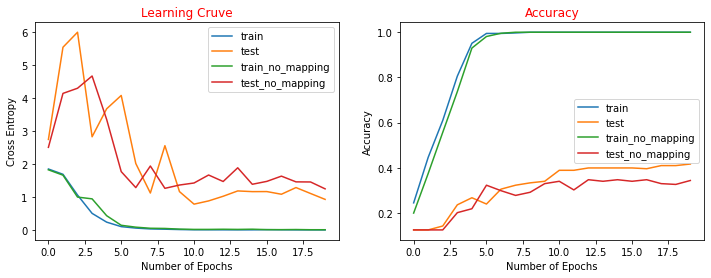

In [19]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_train_loss, label = 'train')
ax[0].plot(history_test_loss, label = 'test')
ax[0].plot(history_train_loss_no_mapping, label = 'train_no_mapping')
ax[0].plot(history_test_loss_no_mapping, label = 'test_no_mapping')
ax[0].legend(loc=1)


ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_test_acc, label = 'test')
ax[1].plot(history_train_acc_no_mapping, label = 'train_no_mapping')
ax[1].plot(history_test_acc_no_mapping, label = 'test_no_mapping')
ax[1].legend(loc=7)

### Resnet-18 在有 identity mapping 的情況下，training 的 loss、accuracy 在收斂速度的表現上差異不大，但在  testing 的表現上，Resnet-18 在有 identity mapping 下，testing accuray 為 41.667%，高於沒有做 identity mapping 的 34.375%。